In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy
%matplotlib inline

In [2]:
from simpegEMIP.SeogiUtils.View import Rectangle2D
import matplotlib 
matplotlib.rcParams["font.size"] = 14
figdir = "../../docs/figures/"

# Step1: Generate 2D Cylindrical Mesh

In [3]:
cs, ncx, ncz, npad = 10., 40, 40, 25
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

# Step2: Generate conductivity and chargeability model

In [4]:
sig_1 = 0.001
sig_2 = 0.1
sigmaInf = np.ones(mesh.nC) * sig_1
airind = mesh.gridCC[:,2]>0.
z = 0.
radius = 200.
z_top = -50
z_bottom = -150
blkind  = np.logical_and(mesh.gridCC[:,0]<radius, (mesh.gridCC[:,2]<z_top)&(mesh.gridCC[:,2]>z_bottom))
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
eta_se, tau_se, c_se = 0.1, 0.001, 0.7
eta = np.zeros(mesh.nC)
eta[blkind] = eta_se
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se

# Step3: Generate `Problem` and `Survey`

In [5]:
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e
from simpegEMIP.TDEM import Rx, Survey

In [6]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.5), 31), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 5), (2e-05, 5), (4e-05, 5), (8e-05, 5), (1.6e-04, 5), (4e-04, 5), (8e-04, 5), (1e-03, 5), (2e-03, 5), (4e-03, 5), (8e-03, 5), (1e-02, 5), (2e-02, 5), (4e-02, 5), (8e-02, 5), (1e-01, 5)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
F = prb_emip.fields(m)
data = survey_emip.dpred(m, f=F)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [7]:
rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.5), 31), 'z')
src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_em = Survey([src_em])
prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 5), (2e-05, 5), (4e-05, 5), (8e-05, 5), (1.6e-04, 5), (4e-04, 5), (8e-04, 5), (1e-03, 5), (2e-03, 5), (4e-03, 5), (8e-03, 5), (1e-02, 5), (2e-02, 5), (4e-02, 5), (8e-02, 5), (1e-01, 5)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey_em)
m = np.r_[sigmaInf, eta, tau, c]
F_em = prb_em.fields(m)
data_em = survey_em.dpred(m, f=F_em)
data_ip = data - data_em

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


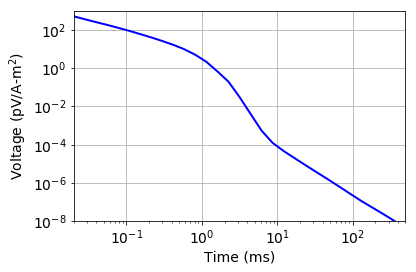

In [8]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
ax.loglog(rx_emip.times*ms, -data_em.flatten()/moment, 'b-', lw=2)
# ax.legend(("d$^{obs}$ (+)", "d$^{obs}$ (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 13, loc=3)
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
ax.set_ylim(1e-8, 1e3)
ax.set_ylabel("Voltage (pV/A-m$^2$)")
plt.tight_layout()
# fig.savefig(figdir+"data_em", dpi=300)

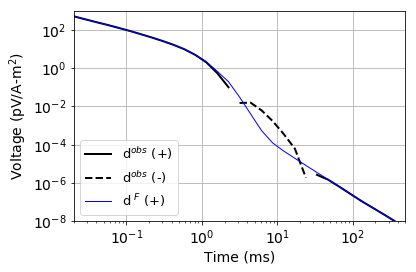

In [9]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
ax.loglog(rx_emip.times*ms, data_n, 'k-', lw=2)
ax.loglog(rx_emip.times*ms, data_p, 'k--', lw=2)
ax.loglog(rx_emip.times*ms, -data_em.flatten()/moment, 'b-', lw=1)
ax.legend(("d$^{obs}$ (+)", "d$^{obs}$ (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 13, loc=3)
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
ax.set_ylim(1e-8, 1e3)
ax.set_ylabel("Voltage (pV/A-m$^2$)")
plt.tight_layout()
# fig.savefig(figdir+"data", dpi=300)

(0.1, 100.0)

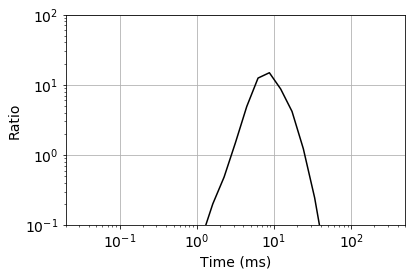

In [10]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
ax.loglog(rx_emip.times*ms, abs(data_ip.flatten()/data_em.flatten()), 'k')
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
ax.set_ylabel("Ratio")
plt.tight_layout()
ax.set_ylim(1e-1, 1e2)
# fig.savefig(figdir+"ratio", dpi=300)

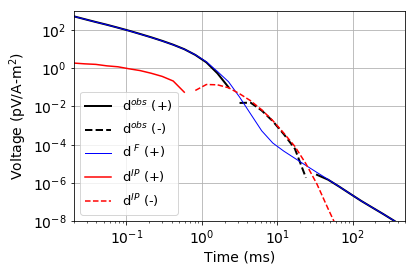

In [11]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
ax.loglog(rx_emip.times*ms, data_n, 'k-', lw=2)
ax.loglog(rx_emip.times*ms, data_p, 'k--', lw=2)
ax.loglog(rx_emip.times*ms, -data_em.flatten()/moment, 'b-', lw=1)
ax.loglog(rx_emip.times*ms, data_ip_n, 'r-')
ax.loglog(rx_emip.times*ms, data_ip_p, 'r--')

ax.legend(("d$^{obs}$ (+)", "d$^{obs}$ (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 13, loc=3)
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
ax.set_ylim(1e-8, 1e3)
ax.set_ylabel("Voltage (pV/A-m$^2$)")
plt.tight_layout()
# fig.savefig(figdir+"data_ip", dpi=300)

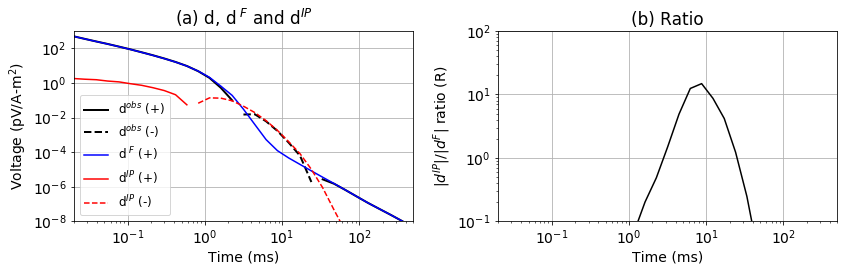

In [12]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, axs = plt.subplots(1,2, figsize = (12, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
axs[0].loglog(rx_emip.times*ms, data_n, 'k-', lw=2)
axs[0].loglog(rx_emip.times*ms, data_p, 'k--', lw=2)
axs[0].loglog(rx_emip.times*ms, -data_em.flatten()/moment, 'b-')
axs[0].loglog(rx_emip.times*ms, data_ip_n, 'r-')
axs[0].loglog(rx_emip.times*ms, data_ip_p, 'r--')
axs[0].legend(("d$^{obs}$ (+)", "d$^{obs}$ (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 12, loc=3)
for ax in axs:
    ax.set_xlabel("Time (ms)")    
    ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
    ax.grid(True)
#     ax.set_xlim(2e-5*ms, 50*ms)
axs[0].set_ylim(1e-8, 1e3)
axs[1].set_ylim(1e-1, 1e2)
ax.grid(True)
# for t in tc:
#     axs[0].loglog(np.ones(2)*t*ms, np.r_[1e-4, 1e4], 'k-', alpha=0.2)
axs[0].set_title("(a) d, d$^{\ F}$ and d$^{IP}$")
axs[0].set_ylabel("Voltage (pV/A-m$^2$)")
axs[1].set_ylabel('$|d^{IP}|/|d^{F}|$ ratio (R)')
# axs[0].set_title("(a) Voltage (variable $\sigma_2$)")
axs[1].set_title("(b) Ratio")
axs[1].loglog(rx_emip.times*ms, abs(data_ip.flatten()/data_em.flatten()), 'k')
    
plt.tight_layout()
fig.savefig(figdir+"data", dpi=300)

In [13]:
x = np.arange(50)*10. + 10.
z = -np.arange(50)*10.
xz = Utils.ndgrid(x, np.r_[0.], z)
x_mirror = np.r_[-x[::-1], x]
xz_mirror = Utils.ndgrid(x_mirror, np.r_[0.], z)

In [14]:
X, Z = np.meshgrid(x_mirror, z)
Y = np.zeros_like(X)

In [15]:
P = mesh.getInterpolationMat(xz, 'Ey')
Pfx = mesh.getInterpolationMat(xz, 'Fx')
Pfz = mesh.getInterpolationMat(xz, 'Fz')

In [16]:
F_em.shape

(5915, 1, 96)

In [17]:
e_em = P * F_em[:,0,:]
e_emip = P * F[:,0,:]

In [18]:
dbdtx_em = Pfx * (-mesh.edgeCurl*F_em[:,0,:])
dbdtz_em = Pfz * (-mesh.edgeCurl*F_em[:,0,:])

In [19]:
dbdtx_emip = Pfx * (-mesh.edgeCurl*F[:,0,:])
dbdtz_emip = Pfz * (-mesh.edgeCurl*F[:,0,:])

In [20]:
def get_e_dbdt_em(i_time):
    temp_r = dbdtx_em[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtx_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_x = np.vstack((-temp_l, temp_r))
    temp_r = dbdtz_em[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtz_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_z = np.vstack((temp_l, temp_r))
    temp_abs = np.sqrt(temp_x**2+temp_z**2)
    temp_r = e_em[:,i_time].reshape((50, 50), order="F")
    temp_l = e_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp = np.vstack((-temp_l, temp_r))
    return temp.T, temp_abs.T, temp_x.T, temp_z.T
def get_e_dbdt_emip(i_time):
    temp_r = dbdtx_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtx_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_x = np.vstack((-temp_l, temp_r))
    temp_r = dbdtz_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtz_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_z = np.vstack((temp_l, temp_r))
    temp_abs = np.sqrt(temp_x**2+temp_z**2)
    temp_r = e_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = e_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp = np.vstack((-temp_l, temp_r))
    return temp.T, temp_abs.T, temp_x.T, temp_z.T

def get_nksip(nkip, M):
    return M[::nksip, ::nskip]

In [21]:
p1 = np.r_[-radius, z_bottom]
p2 = np.r_[radius, z_top]
xy_box = rect2D(p1, p2)

In [22]:
times_for_plot = np.r_[0.01, 0.3, 6, 50] * 1e-3
i_times = [np.argmin(abs(prb_em.times-time)) for time in times_for_plot]

In [23]:
import matplotlib 
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["image.cmap"] = "viridis"
fig_dir = "../../docs/figures/"

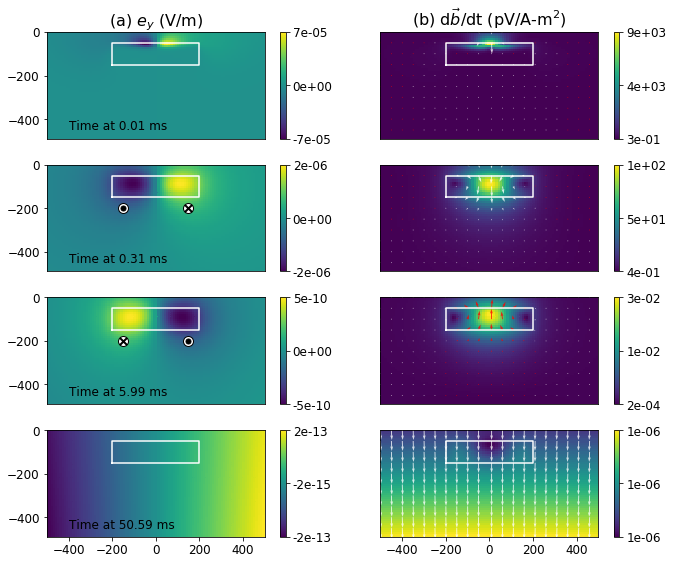

In [25]:
fig, axs = plt.subplots(4,2, figsize = (10, 8))
nskip = 5

for i in range(4):
    temp, temp_abs, temp_x, temp_z = get_e_dbdt_emip(i_times[i])
    im1 = axs[i,0].pcolormesh(x_mirror, z, temp)
    temp_abs_skip = temp_abs[::nskip, ::nskip]    
    im2 = axs[i,1].pcolormesh(x_mirror, z, temp_abs/moment)
    vmax = temp_abs.max()
    x_skip, z_skip, temp_x_skip, temp_z_skip = x_mirror[::nskip], z[::nskip], temp_x[::nskip, ::nskip]/vmax, temp_z[::nskip, ::nskip]/vmax,
    inds_p = temp_z_skip>0.
    temp_x_skip_p = temp_x_skip.copy()
    temp_z_skip_p = temp_z_skip.copy()
    temp_x_skip_n = temp_x_skip.copy()
    temp_z_skip_n = temp_z_skip.copy()
    temp_x_skip_p[~inds_p] = np.nan
    temp_z_skip_p[~inds_p] = np.nan
    temp_x_skip_n[inds_p] = np.nan
    temp_z_skip_n[inds_p] = np.nan    
    
    im2_1 = axs[i,1].quiver(
        x_skip, z_skip, temp_x_skip_p, temp_z_skip_p,
        scale=20, color='r', alpha=0.8,
    )
    im2_2 = axs[i,1].quiver(
        x_skip, z_skip, temp_x_skip_n, temp_z_skip_n,
        scale=20, color='w', alpha=0.8,
    )
    axs[i,0].plot(xy_box[:,0], xy_box[:,1], 'w-')
    axs[i,1].plot(xy_box[:,0], xy_box[:,1], 'w-')
    
    axs[i,0].set_aspect(1)
    axs[i,1].set_aspect(1)
    vmin, vmax = im1.get_clim()
    cb1 = plt.colorbar(im1, ax=axs[i,0], format="%.e", fraction=0.02, ticks=np.linspace(vmin, vmax,3))
    vmin, vmax = im2.get_clim()    
    cb1 = plt.colorbar(im2, ax=axs[i,1], format="%.e", fraction=0.02, ticks=np.linspace(vmin, vmax,3))
    axs[i,1].set_yticks([])
    axs[i,0].text(-400, -450, ("Time at %.2f ms")%((prb_em.times[i_times[i]])*1e3), fontsize=12)    
    if i<3:
        axs[i,0].set_xticks([])        
        axs[i,1].set_xticks([]) 
axs[0,0].set_title("(a) $e_y$ (V/m)", fontsize=16)
axs[0,1].set_title("(b) d$\\vec{b}$/dt (pV/A-m$^2$)", fontsize=16)

axs[1,0].plot(150, -200, 'o', markersize = 10, markerfacecolor='w', markeredgecolor='k', markeredgewidth=1)
axs[1,0].plot(150, -200, 'kx', markersize = 7, markeredgewidth=2)
axs[1,0].plot(-150, -200, 'o', markersize = 10, markerfacecolor='w', markeredgecolor='k', markeredgewidth=1)
axs[1,0].plot(-150, -200, 'ko', markersize = 5)

axs[2,0].plot(-150, -200, 'o', markersize = 10, markerfacecolor='w', markeredgecolor='k', markeredgewidth=1)
axs[2,0].plot(-150, -200, 'kx', markersize = 7, markeredgewidth=2)
axs[2,0].plot(150, -200, 'o', markersize = 10, markerfacecolor='w', markeredgecolor='k', markeredgewidth=1)
axs[2,0].plot(150, -200, 'ko', markersize = 5)
plt.tight_layout()
fig.savefig(fig_dir + "fields", dpi=200)

(<matplotlib.collections.QuadMesh at 0x1848cd7e48>,
 Text(-400,-400,'Time at 2.8e+00 ms'))

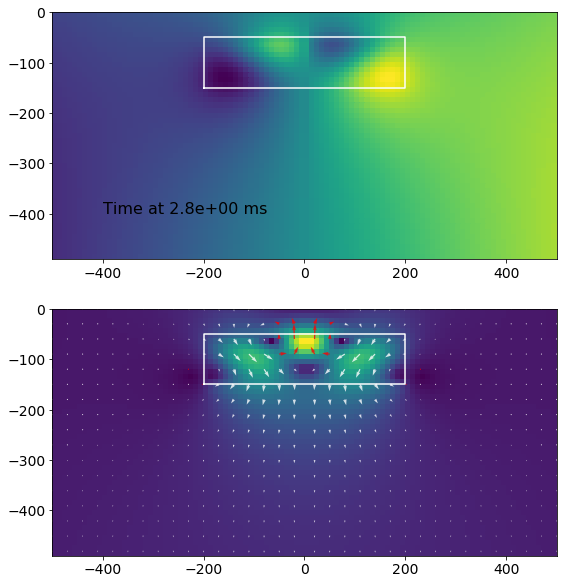

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
video_names = ['em.mp4', 'emip.mp4']
# for i in range(2):
i=1
fig = plt.figure(figsize=(10, 10))
temp, temp_abs, temp_x, temp_z = get_e_dbdt_em(10)
nskip = 3
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(xy_box[:,0], xy_box[:,1], 'w-')
ax2.plot(xy_box[:,0], xy_box[:,1], 'w-')

ax2.set_aspect(1)
time_text = ax1.text(-400, -400, '', fontsize=16)
def init():
    temp, temp_abs, temp_x, temp_z = get_e_dbdt_em(0)
    im1 = ax1.pcolormesh(x_mirror, z, temp)
    temp_abs_skip = temp_abs[::nskip, ::nskip]
    im2 = ax2.pcolormesh(x_mirror, z, temp_abs)
    vmax = temp_abs.max()
    im2_1 = ax2.quiver(
        x_mirror[::nskip], z[::nskip], 
        temp_x[::nskip, ::nskip]/temp_abs_skip, temp_z[::nskip, ::nskip]/temp_abs_skip, 
        scale=30, color='w', alpha=0.8,
    )
    time_text.set_text('')
    return im1, im2, im2_1, time_text

def animate(i_time):    
    if i == 0:
        temp, temp_abs, temp_x, temp_z = get_e_dbdt_em(i_time)
    else:
        temp, temp_abs, temp_x, temp_z = get_e_dbdt_emip(i_time)
    im1 = ax1.pcolormesh(x_mirror, z, temp)
    temp_abs_skip = temp_abs[::nskip, ::nskip]    
    im2 = ax2.pcolormesh(x_mirror, z, temp_abs)
    vmax = temp_abs.max()
    x_skip, z_skip, temp_x_skip, temp_z_skip = x_mirror[::nskip], z[::nskip], temp_x[::nskip, ::nskip]/vmax, temp_z[::nskip, ::nskip]/vmax,
    inds_p = temp_z_skip>0.
    temp_x_skip_p = temp_x_skip.copy()
    temp_z_skip_p = temp_z_skip.copy()
    temp_x_skip_n = temp_x_skip.copy()
    temp_z_skip_n = temp_z_skip.copy()
    temp_x_skip_p[~inds_p] = np.nan
    temp_z_skip_p[~inds_p] = np.nan
    temp_x_skip_n[inds_p] = np.nan
    temp_z_skip_n[inds_p] = np.nan    
    
    im2_1 = ax2.quiver(
        x_skip, z_skip, temp_x_skip_p, temp_z_skip_p,
        scale=30, color='r', alpha=0.8,
    )
    im2_2 = ax2.quiver(
        x_skip, z_skip, temp_x_skip_n, temp_z_skip_n,
        scale=30, color='w', alpha=0.8,
    )
    
    time_text.set_text(("Time at %.1e ms")%((prb_em.times[i_time])*1e3)) 
    ax1.set_aspect(1)
    ax2.set_aspect(1)
    return im1, im2, im2_1, im2_2, time_text

# ani = animation.FuncAnimation(fig, animate, prb_em.times.size-1, interval=200, blit=True,
#                                 repeat_delay=1000)
# ani = animation.FuncAnimation(fig, animate, int(5), interval=200, blit=True,
#                                 repeat_delay=1000)
# ani.save(video_names[i], dpi=100)

animate(43)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xy_box[:,0], np.zeros(xy_box.shape[0])-10., xy_box[:,1], 'k-')
X_skip, Y_skip, Zskip = X[::nskip,::nskip], Y[::nskip,::nskip], Z[::nskip,::nskip]
ax.set_ylim(-300, 300)
ax.set_xlim(-500, 500)
ax.set_zlim(-500, 0)
ax.set_aspect(1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
time_text = ax.text(-700, 0, 500, '', fontsize=14)
    
def init():    
    return 
    
def animate(i_time):    
    temp_r = e_em[:,i_time].reshape((50, 50), order="F")
    temp_l = e_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp = np.vstack((-temp_l, temp_r))

    cont  = ax.contourf3D(X, temp.T, Z, 100, zdir='y', offset=0, alpha=0.9)

    temp_skip = temp[::nskip,::nskip].T
    temp_skip_p = temp_skip.copy() / temp_skip.max()
    temp_skip_p[temp_skip<0.] = np.nan
    temp_skip_n = temp_skip.copy() / temp_skip.max()
    temp_skip_n[temp_skip>0.] = np.nan 
    quiv_p = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_p, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2,
                color='r'
    )
    quiv_r = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_n, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2, 
                color='b'
    )    

    return cont

# ani = animation.FuncAnimation(fig, animate, int(prb_em.times.size-1), interval=200)
ani = animation.FuncAnimation(fig, animate, 10, interval=200)
ani.save('test.mp4', dpi=100)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
def viz_e(i_time):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xy_box[:,0], np.zeros(xy_box.shape[0])-10., xy_box[:,1], 'k-')
    X_skip, Y_skip, Zskip = X[::nskip,::nskip], Y[::nskip,::nskip], Z[::nskip,::nskip]
    ax.set_ylim(-300, 300)
    ax.set_xlim(-500, 500)
    ax.set_zlim(-500, 0)
    ax.set_aspect(1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    time_text = ax.text(-700, 0, 500, '', fontsize=14)
    temp_r = e_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = e_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp = np.vstack((-temp_l, temp_r))

    cont  = ax.contourf3D(X, temp.T, Z, 100, zdir='y', offset=0, alpha=0.5)

    temp_skip = temp[::nskip,::nskip].T
    vmax = abs(temp_skip).max()
    temp_skip_p = temp_skip.copy() / vmax
    temp_skip_p[temp_skip<0.] = np.nan
    temp_skip_n = temp_skip.copy() / vmax
    quiv_p = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_p, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2,
                color='r'
    )
    quiv_r = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_n, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2, 
                color='b'
    )  
def viz_e_em(i_time):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xy_box[:,0], np.zeros(xy_box.shape[0])-10., xy_box[:,1], 'k-')
    X_skip, Y_skip, Zskip = X[::nskip,::nskip], Y[::nskip,::nskip], Z[::nskip,::nskip]
    ax.set_ylim(-300, 300)
    ax.set_xlim(-500, 500)
    ax.set_zlim(-500, 0)
    ax.set_aspect(1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    time_text = ax.text(-700, 0, 500, '', fontsize=14)
    temp_r = e_em[:,i_time].reshape((50, 50), order="F")
    temp_l = e_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp = np.vstack((-temp_l, temp_r))

    cont  = ax.contourf3D(X, temp.T, Z, 100, zdir='y', offset=0, alpha=0.5)

    temp_skip = temp[::nskip,::nskip].T
    vmax = abs(temp_skip).max()
    temp_skip_p = temp_skip.copy() / vmax
    temp_skip_p[temp_skip<0.] = np.nan
    temp_skip_n = temp_skip.copy() / vmax
    temp_skip_n[temp_skip>0.] = np.nan 
    quiv_p = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_p, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2,
                color='r'
    )
    quiv_r = ax.quiver3D(X_skip, Y_skip, Zskip, 
                np.zeros_like(temp_skip), temp_skip_n, np.zeros_like(temp_skip),
                normalize=False,
                length = 70,
                arrow_length_ratio = 0.5, 
                lw=0.2, 
                color='b'
    )      

In [ ]:
!pwd

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def viz_dbdt(i_time):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xy_box[:,0], np.zeros(xy_box.shape[0])-10., xy_box[:,1], 'k-')
    X_skip, Y_skip, Zskip = X[::nskip,::nskip], Y[::nskip,::nskip], Z[::nskip,::nskip]
    ax.set_ylim(-300, 300)
    ax.set_xlim(-500, 500)
    ax.set_zlim(-500, 0)
    ax.set_aspect(1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    time_text = ax.text(-700, 0, 500, '', fontsize=14)
    temp_r = dbdtx_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtx_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_x = np.vstack((-temp_l, temp_r))
    temp_r = dbdtz_emip[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtz_emip[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_z = np.vstack((temp_l, temp_r))
    temp = np.sqrt(temp_x**2 + temp_z**2)
    cont  = ax.contourf3D(X, temp.T, Z, 200, zdir='y', offset=0, alpha=0.9)

    temp_x_skip = temp_x[::nskip,::nskip].T / temp.max()
    temp_z_skip = temp_z[::nskip,::nskip].T / temp.max()
    quiv = ax.quiver3D(X_skip, Y_skip, Zskip, 
                temp_x_skip, np.zeros_like(temp_x_skip), temp_z_skip,
                normalize=False,
                length = 40,
                arrow_length_ratio = 0.5, 
                lw=1,
                color='w',
                alpha=0.5,
    )

def viz_dbdt_em(i_time, dtype='em'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xy_box[:,0], np.zeros(xy_box.shape[0])-10., xy_box[:,1], 'k-')
    X_skip, Y_skip, Zskip = X[::nskip,::nskip], Y[::nskip,::nskip], Z[::nskip,::nskip]
    ax.set_ylim(-300, 300)
    ax.set_xlim(-500, 500)
    ax.set_zlim(-500, 0)
    ax.set_aspect(1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    time_text = ax.text(-700, 0, 500, '', fontsize=14)
    temp_r = dbdtx_em[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtx_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_x = np.vstack((-temp_l, temp_r))
    temp_r = dbdtz_em[:,i_time].reshape((50, 50), order="F")
    temp_l = dbdtz_em[:,i_time].reshape((50, 50), order="F")[::-1, :]
    temp_z = np.vstack((temp_l, temp_r))
    temp = np.sqrt(temp_x**2 + temp_z**2)
    cont  = ax.contourf3D(X, temp.T, Z, 200, zdir='y', offset=0, alpha=0.9)

    temp_x_skip = temp_x[::nskip,::nskip].T / temp.max()
    temp_z_skip = temp_z[::nskip,::nskip].T / temp.max()
    quiv = ax.quiver3D(X_skip, Y_skip, Zskip, 
                temp_x_skip, np.zeros_like(temp_x_skip), temp_z_skip,
                normalize=False,
                length = 40,
                arrow_length_ratio = 0.5, 
                lw=1,
                color='w',
                alpha=0.5,
    )
from ipywidgets import interact, IntSlider    

In [ ]:
interact(viz_e_em, i_time = IntSlider(min=0, max=95, step=1, value=1))

In [375]:
interact(viz_e, i_time = IntSlider(min=0, max=95, step=1, value=1))

interactive(children=(IntSlider(value=1, description='i_time', max=95), Output()), _dom_classes=('widget-interact',))

<function __main__.viz_e>

In [361]:
interact(viz_dbdt, i_time = IntSlider(min=0, max=95, step=1, value=1))

interactive(children=(IntSlider(value=1, description='i_time', max=95), Output()), _dom_classes=('widget-interact',))

<function __main__.viz_dbdt>

In [363]:
interact(viz_dbdt_em, i_time = IntSlider(min=0, max=95, step=1, value=1))

interactive(children=(IntSlider(value=1, description='i_time', max=95), Output()), _dom_classes=('widget-interact',))

<function __main__.viz_dbdt_em>

In [ ]:
interact(viz_dbdt, i_time = IntSlider(min=0, max=95, step=1, value=1))